# Third model: TFIDF + complexity features

In [91]:
import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

In [92]:
import time
start = time.time()

import itertools
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score

import gc

In [93]:
df = pd.read_csv('~/TFM_fake_news_detector/data/corpus_features.csv', index_col = 0)

In [94]:
df_index = df.index

In [95]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and sºtoring in another column
df['Labels'] = labelencoder.fit_transform(df['Category'])

# True == 1 and False == 0
y = df['Labels']

## TfidfVectorizer

The TfidfVectorizer serves us to convert a collection of raw documents into a matrix of TF and IDF features.

### IDF (Inverse Document Frequency)

The IDF is used to calculate how many times a word appears on a set of documents.

### TF (Term Frequency)

The TF, unlike the IDF is the number of times a word appears in a single document.

## Spanish tokenization

    - Spanish stopwords
    - Added more spanish punctuation
    - Created stems with lemmas, using the rooting word

In [96]:
#Stopword list to use
spanish_stopwords = stopwords.words('spanish')

In [97]:
#Spanish stemmer: Stemming is the process to transform any word into its rooting word, considering them as the same word
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [98]:
#Punctuation to remove
non_words = list(punctuation)

#Adding spanish punctuation
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

In [99]:
def tokenize(text):  
    #Remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    #Tokenize
    tokens =  word_tokenize(text)

    #Stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

## TFIDF Vectorizer transformation with the tokenization explaned

In [100]:
tfidf_vectorizer = TfidfVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

### Transformation

In [101]:
text_vectorized = tfidf_vectorizer.fit_transform(df['Text']) 

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [102]:
tfvocab = tfidf_vectorizer.get_feature_names()

### Make Dense dataframe Sparse, and Combine with TF-IDF features

In [103]:
categorical_features = ['sentences', 'n_words', 'avg_words_sent', 'avg_word_size', 'TTR']

X = hstack([csr_matrix(df[categorical_features].values), text_vectorized[0:]])
tfvocab = df[categorical_features].columns.tolist() + tfvocab

for shape in [X]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ", len(tfvocab))
gc.collect();

971 Rows and 15569 Cols
Feature Names Length:  15569


### Split in training and test for validation

In [104]:
# Calculating level of imbalance for future models.
imbalance_weight = y.value_counts(normalize=True)[0] / y.value_counts(normalize=True)[1]
print("Imbalance Weight: ", imbalance_weight)

Imbalance Weight:  0.9775967413441956


In [118]:
# Training and Validation Set
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size = 0.3, random_state = 23)

In [119]:
# XGBOOST Sparse Feature Storage
d_train = xgb.DMatrix(X_train, y_train, feature_names = tfvocab)
d_valid = xgb.DMatrix(X_valid, y_valid, feature_names = tfvocab)

## Model: XGB

In [146]:
xgb_params = {'eta': 0.04, 
              'max_depth': 12, 
              'subsample': 0.8, 
              'colsample_bytree': 0.75,
              #'min_child_weight' : 1.5,
              'scale_pos_weight': imbalance_weight,
              'objective': 'binary:logistic', 
              'eval_metric': 'auc', 
              'seed': 23,
              'lambda': 1.5,
              'alpha': .6
             }

In [150]:
modelstart = time.time()
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model = xgb.XGBClassifier(xgb_params, d_train, n_estimators = 200, watchlist = [(d_train, 'train'), (d_valid, 'valid')]
                          , verbose_eval = 30, early_stopping_rounds = 30)

print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart) / 60))

print("Best error: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

TypeError: __init__() takes from 1 to 2 positional arguments but 3 were given

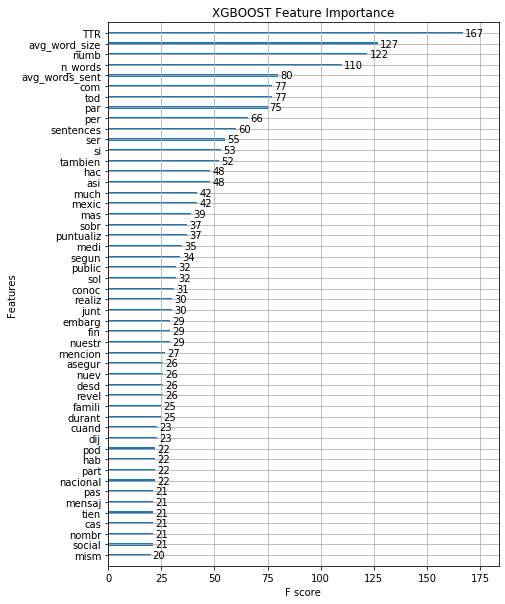

In [141]:
f, ax = plt.subplots(figsize = [7,10])
xgb.plot_importance(model,max_num_features = 50,ax = ax)
plt.title("XGBOOST Feature Importance")
plt.show()

## Predictions & results

In [142]:
y_pred = model.predict(d_valid)

In [145]:
y_pred

array([0.1719394 , 0.5190205 , 0.7474392 , 0.8754335 , 0.79897135,
       0.0700499 , 0.41809058, 0.02230711, 0.31340778, 0.03751165,
       0.8334714 , 0.08873258, 0.86503625, 0.7387707 , 0.985838  ,
       0.05111165, 0.922575  , 0.14445399, 0.05691275, 0.85555   ,
       0.26160023, 0.8666745 , 0.11985849, 0.94920623, 0.67725146,
       0.84176403, 0.42646417, 0.22470048, 0.06288422, 0.71594566,
       0.15043731, 0.52790874, 0.9493814 , 0.04165402, 0.15350665,
       0.9223695 , 0.7554337 , 0.71058583, 0.09155346, 0.17907076,
       0.11237909, 0.08770473, 0.19545084, 0.53726244, 0.04201237,
       0.78731954, 0.8696532 , 0.80322254, 0.261886  , 0.06756862,
       0.5867763 , 0.4612638 , 0.14206786, 0.23127444, 0.9643508 ,
       0.74483466, 0.60192   , 0.07982633, 0.9271951 , 0.897261  ,
       0.89856744, 0.11468593, 0.5980025 , 0.20699793, 0.15312393,
       0.67208666, 0.834553  , 0.17872474, 0.44989657, 0.919059  ,
       0.6794469 , 0.5763063 , 0.7437544 , 0.12807707, 0.79665

In [144]:
type(y_pred)

numpy.ndarray

In [ ]:
y_pred
for value in y_pred:
    if value > 0.5:
        value == 1
    else:
        value == 0

In [143]:
# y_pred = model.predict(d_valid)
score = accuracy_score(y_valid, y_pred)
print(f'Accuracy: {round(score * 100, 2)}%')

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [72]:
cf_matrix = confusion_matrix(y_test,y_pred, labels = ['Fake','True'])
print(cf_matrix)

[[ 24 116]
 [  8 144]]


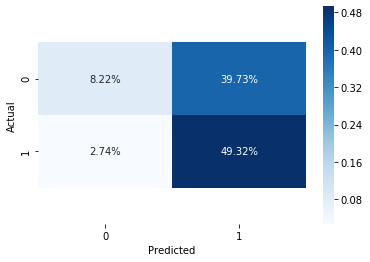

In [73]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()